Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

#### <font color='orange'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Отлично, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

# Прогнозирование заказов такси


## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## План выполнения проекта

* Загрузить данные и выполнить их ресемплирование по одному часу.

* Проанализировать данные.

* Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

* Проверить данные на тестовой выборке и сделать выводы.

## Описание данных

* Данные лежат в файле /datasets/taxi.csv

* Количество заказов находится в столбце 'num_orders' 

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import lightgbm as lgb

from matplotlib import pyplot as plt

import warnings

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## 1) Предобработка и ресемплирование

In [2]:
try: 
    data = pd.read_csv('taxi.csv', index_col='datetime')
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col='datetime')
    
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.index.is_monotonic

True

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0+ KB


Данные отсортированы по времени, пропуски отсутствуют

**Ресемплирование по часу:**

In [5]:
data.index = pd.to_datetime(data.index)
data = data.resample('H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Ресемплинг сделан неверно, так как при использовании агрегирующей функции "mean" мы будем предсказывать среднее по 10 минутным интервалам за следующий час. Корректно будет использовать ".sum()" вместо ".mean()"
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Исправил
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

# 2) Предварительный анализ

**rolling mean, rolling standard deviation**

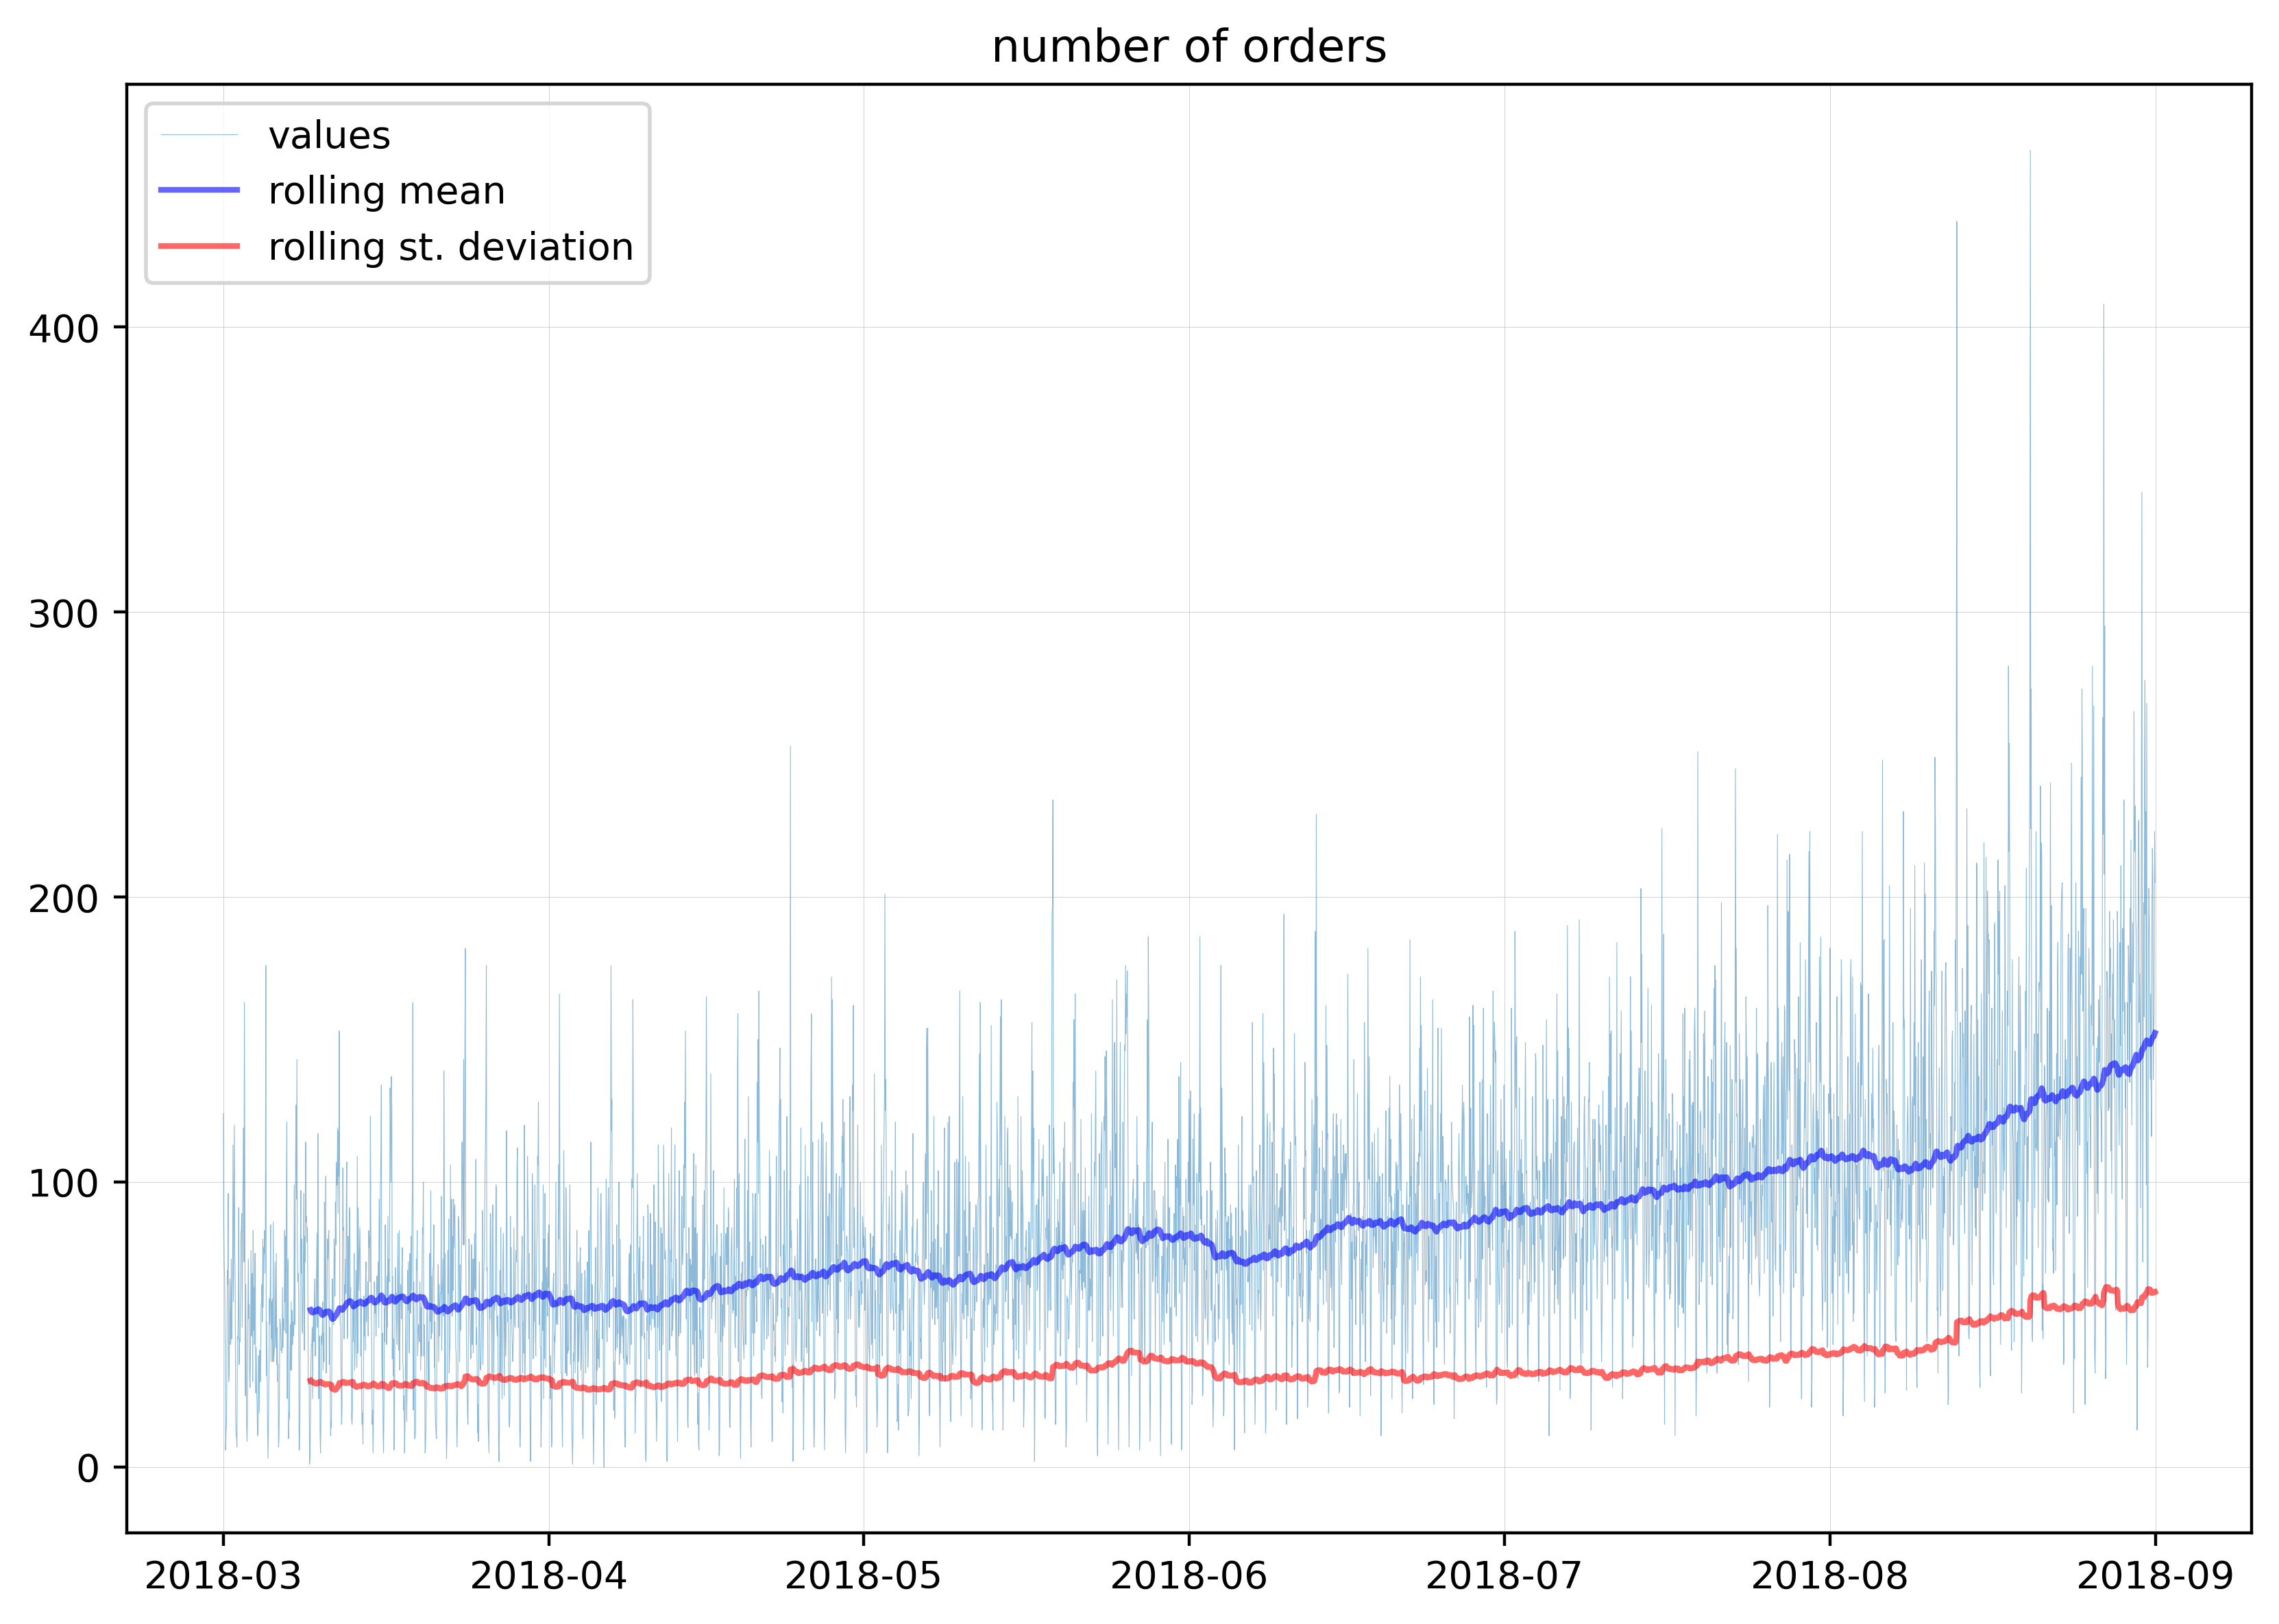

In [6]:
fig = plt.figure(figsize=(10, 7), dpi=400)
plt.plot(data, alpha=0.5, lw=0.2); 
plt.plot(data.rolling(200).mean(), lw=1.5, alpha=0.6, color='blue'); 
plt.plot(data.rolling(200).std(), lw=1.5, alpha=0.6, color='red')
plt.grid(visible=True, lw=0.1)
plt.title('number of orders')
plt.legend(['values', 'rolling mean', 'rolling st. deviation'])
plt.show()

Из графика зависимости заказов от времени видно, что в среднем число заказов растет, также растет стандартное отклониение: в марте оно было ~25, в сентябре - 60. 

**seasonal decompose:**

In [7]:
decomposed = seasonal_decompose(data)

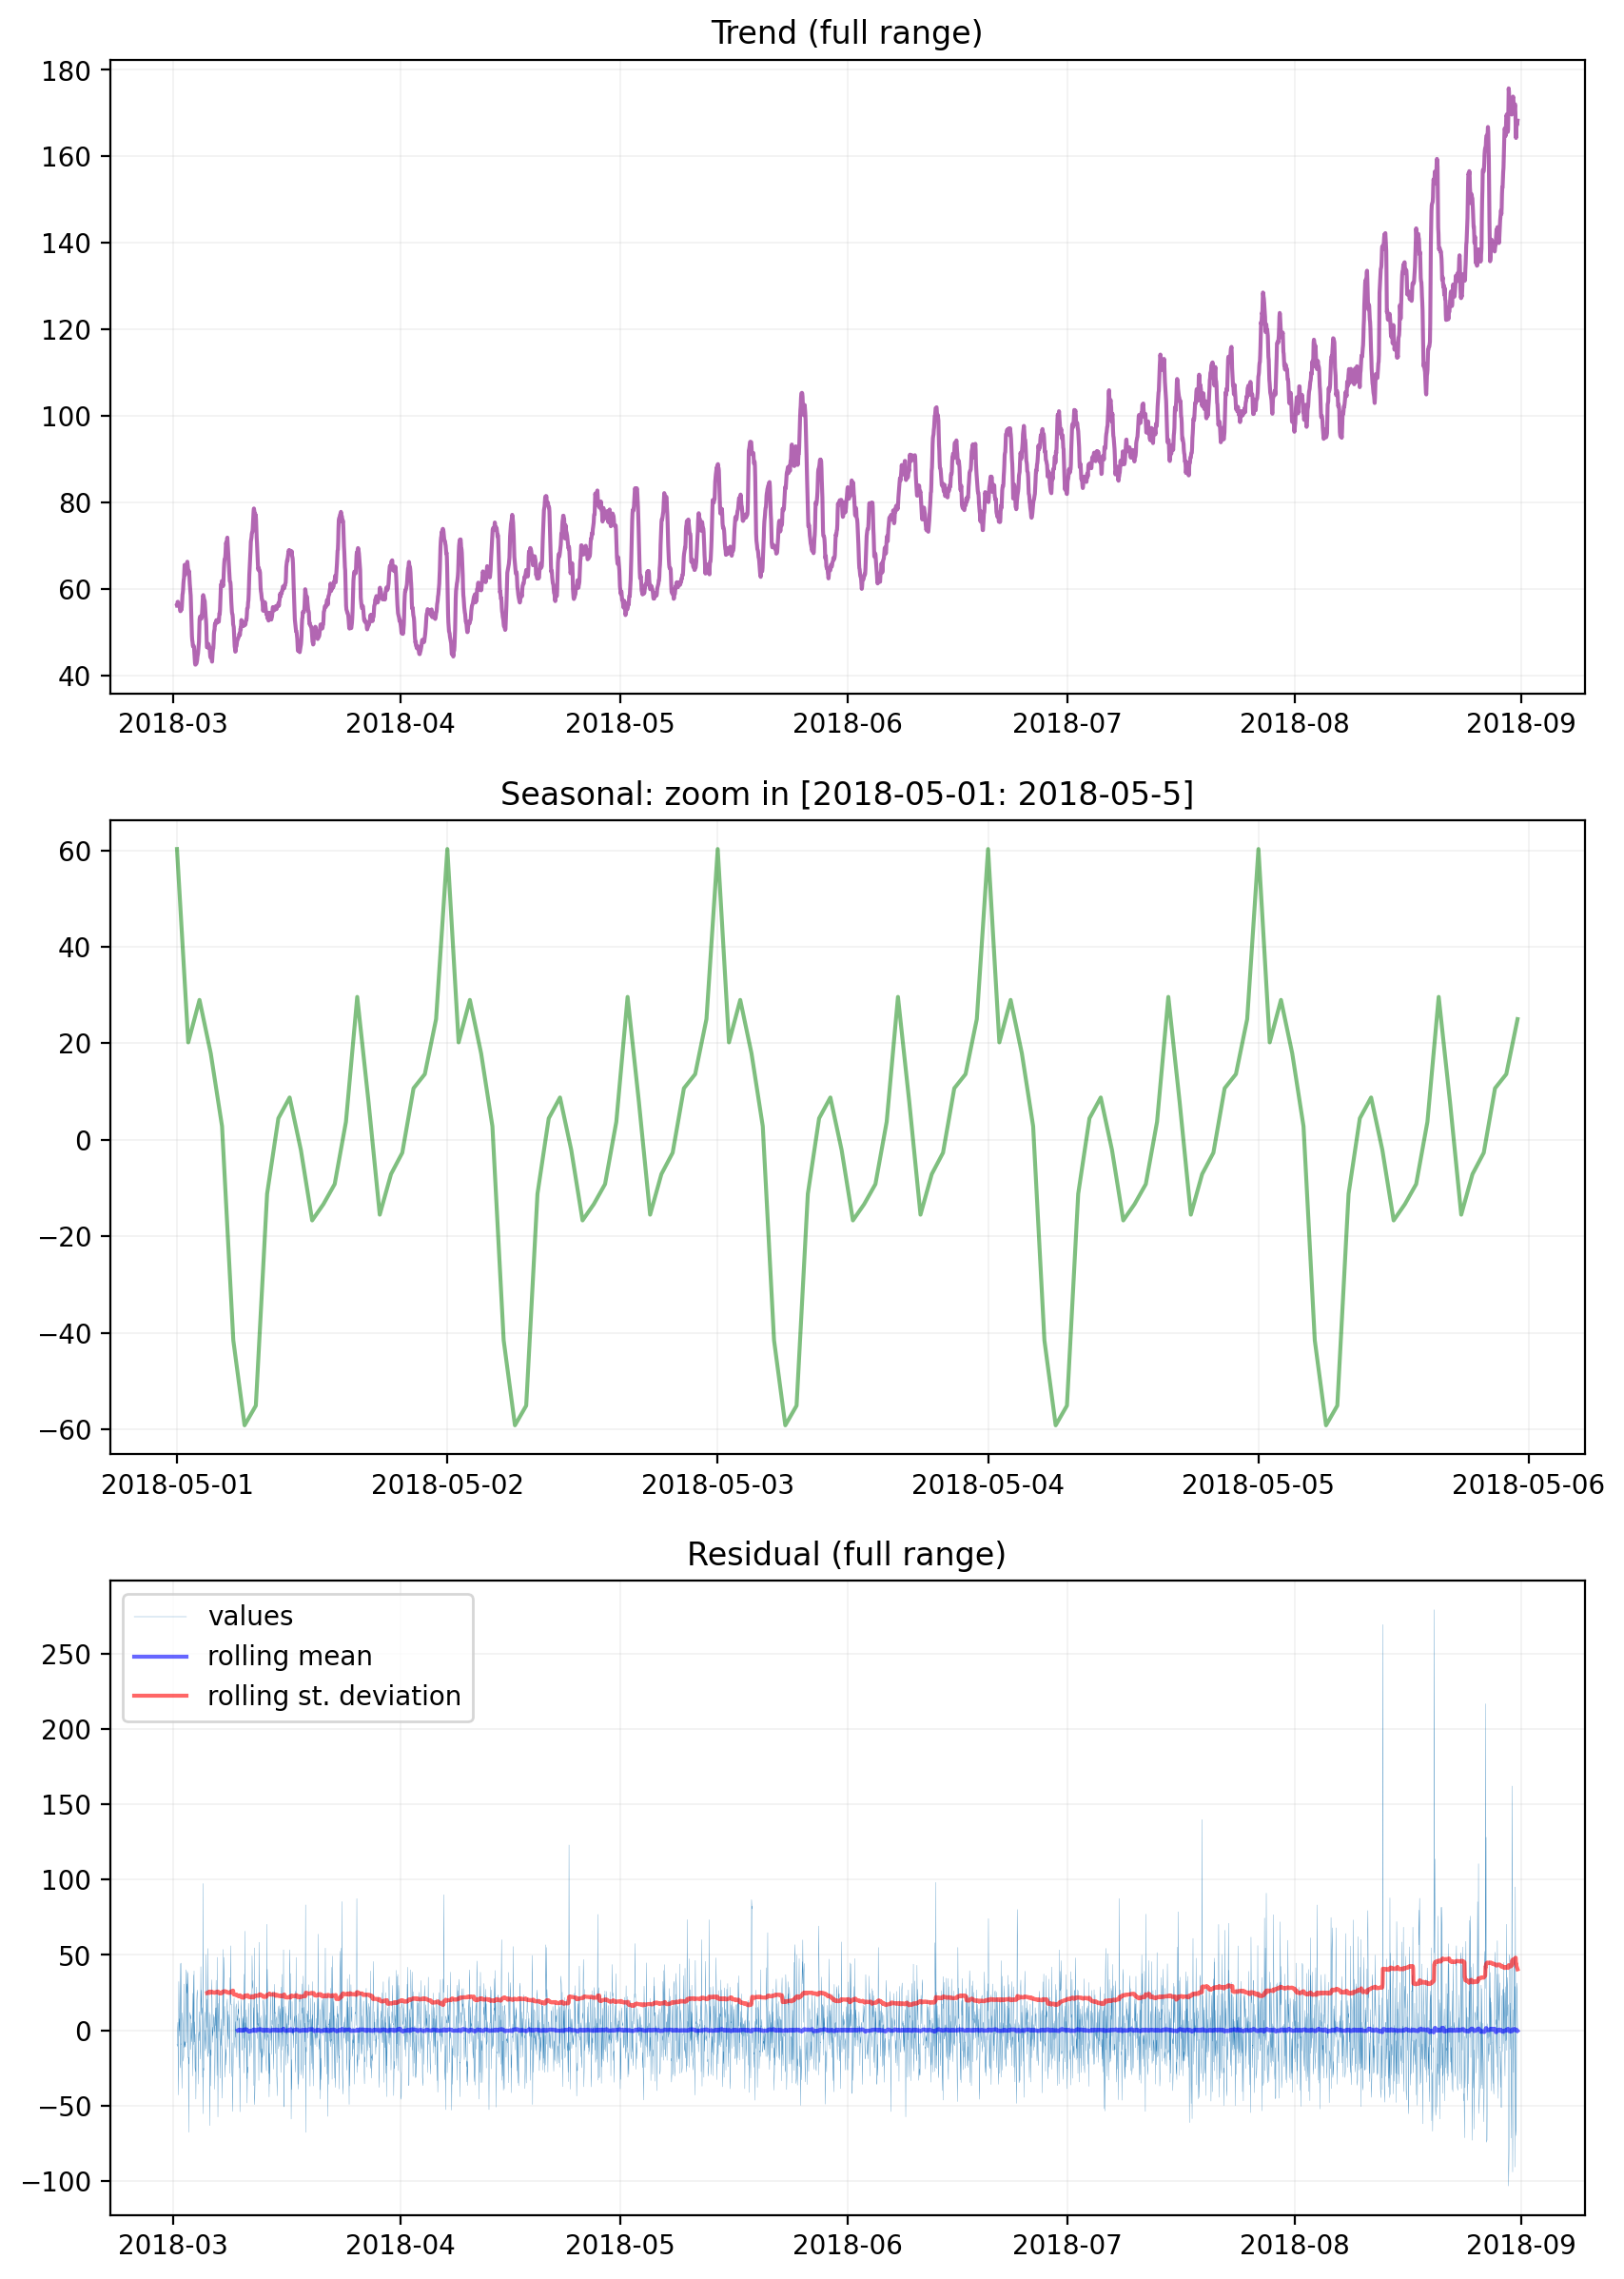

In [8]:
fig, axs = plt.subplots(3, figsize=(10, 15), dpi=200)

fig.size=(10,2)
[axs[i].grid(visible=True, lw=0.1) for i in range(3)]

axs[0].plot(decomposed.trend, alpha=0.6, color='purple') 
axs[0].set_title('Trend (full range)')

axs[1].plot(decomposed.seasonal['2018-05-01':'2018-05-5'], alpha=0.5, color='green') 
axs[1].set_title('Seasonal: zoom in [2018-05-01: 2018-05-5]')

axs[2].plot(decomposed.resid, lw=0.1); 
axs[2].plot(decomposed.resid.rolling(200).mean(), alpha=0.6, color='blue')
axs[2].plot(decomposed.resid.rolling(100).std(),alpha=0.6, color='red')
axs[2].legend(['values', 'rolling mean', 'rolling st. deviation'])
axs[2].set_title('Residual (full range)')
plt.show()

Из графиков, приведенных выше, видно, что присутствует тренд к росту, есть сезонность с шириной в 1 день (в течение всего времени вид не менялся). Также можно отметить остаток, флуктуация которого увеличивается со временем.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

# 3) Создание признаков и выборок

Создадим признаки: `day_of_month`, `day_of_week`, `month`, `rolling_mean`, `n_lag`

In [9]:
target = 'num_orders'
rmse_level = 48 

In [10]:
def make_features(df, rol_size, n_lag):
    data = df.copy()
    data['day_of_week'] = data.index.dayofweek
    data['day_of_month'] = data.index.day
    data['month'] = data.index.month
    data['rolling_mean'] = data[target].shift().rolling(rol_size).mean()
    
    for i in range(n_lag):
        data[f'{i+1}_lag'] = data[target].shift(i+1) 
    
    data.dropna(inplace=True)
    return data
    

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что эта функция не изменяет глоабльную переменную!
</div>

## 4) Подбор оптимальных параметров rolling_mean и n_lag для модели линейной регрессии

In [11]:
alpha = 0.1

In [12]:
tscv = TimeSeriesSplit(n_splits=7)

In [13]:
def split(data, alpha): 
    X = dict()
    y = dict()
    train, test = train_test_split(data, shuffle=False, test_size=alpha)
    
    X['train'], y['train']= train.drop([target], axis=1), train[target]
    X['test'], y['test'] = test.drop([target], axis=1), test[target]
    return X, y

get data_trains tail 

In [14]:
def train_frac(X, y, frac): 
    n = int(X.shape[0] * (1 - frac))
    return X.iloc[n:].copy(), y.iloc[n:].copy()

In [15]:
model = LinearRegression()
df = make_features(data, 24, 1)

X, y = split(df, alpha)

rmse = ((-1 * cross_val_score(model, X['train'], y['train'], cv=tscv, scoring='neg_mean_squared_error'))**0.5).mean()

print(rmse)

31.288246084312476


Можно видеть, что модель обычной линейной регрессии показывает достаточно низкое значение RMSE со скользящим средним за предыдущие 24 часа и сдвинутым столбцом n_orders на 1. 

In [16]:
rol_mean_range = range(10, 97)
n_lags_range = range(1, 25)

best_RMSE = 10000
n_lag = 0
rol_wind_size = 0

In [17]:
for n in n_lags_range: 
    for wind_size in rol_mean_range: 
        model = LinearRegression()
        df = make_features(data, wind_size, n)
        X, y = split(df, alpha)
        
        rmse = ((-1 * cross_val_score(model, X['train'], y['train'], cv=tscv, scoring='neg_mean_squared_error'))**0.5).mean()
        
        if rmse < best_RMSE: 
            best_RMSE = rmse
            n_lag = n
            rol_wind_size = wind_size
            regression = model

finding optimal fraction of rows in train data

In [18]:
print('best_RMSE:', round(best_RMSE, 3))
print('n_lag:', n_lag)
print('rol_wind_size:', rol_wind_size)

df = make_features(data, rol_wind_size, n_lag)
X, y = split(df, alpha)

best_RMSE: 26.222
n_lag: 24
rol_wind_size: 33


## 4) Подбор оптимальных параметров для модели градиентного бустинга LightGBM

In [19]:
warnings.filterwarnings("ignore")

In [20]:
num_it = 100
params = {}
params['num_leaves'] = range(10, 50, 4)
params['max_bin'] = range(100, 1000, 100)

In [21]:
best_params = {'num_leaves': 50, 
               'max_bin': 100, 
               'RMSE': 1e10,}

finding the optimal parameter `min_data_in_leaf`

In [22]:
for i in params['num_leaves']: 
    boost = lgb.LGBMRegressor(metric='mse', 
                              num_leaves=i,
                              num_iterations=200)
    rmse =((-1*cross_val_score(boost, X['train'], y['train'], cv=tscv, scoring='neg_mean_squared_error')).mean())**0.5
#     rmse = MSE(y['valid'], y_pred) ** 0.5
    if best_params['RMSE'] > rmse: 
        best_params['RMSE'] = rmse
        best_params['num_leaves'] = i

finding the optimal parameter `max_bin`

In [23]:
for i in params['max_bin']: 
    boost = lgb.LGBMRegressor(metric='mse', 
                              max_bin=i,
                              num_leaves=best_params['num_leaves'], 
                              num_iterations=200)

    rmse =((-1*cross_val_score(boost, X['train'], y['train'], cv=tscv, scoring='neg_mean_squared_error'))**0.5).mean()
        
    if best_params['RMSE'] > rmse: 
        best_params['RMSE'] = rmse
        best_params['max_bin'] = i
best_params['RMSE']

25.464198616400804

<div class="alert alert-block alert-info">

<b>Совет: </b> Можно было подобрать параметры с помощью кросс-валидации. При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Сделал так, метрика rmse на кросс-валидации снизилась
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

finding the optimal tail of train_data

testing on valid data

In [24]:
num_it = 200
boost = lgb.LGBMRegressor(metric='mse', 
                          max_bin=best_params['max_bin'],
                          num_leaves=best_params['num_leaves'], 
                          num_iterations=num_it)

rmse =((-1*cross_val_score(boost, X['train'], y['train'], cv=tscv, scoring='neg_mean_squared_error'))**0.5).mean()

print('RMSE:', round(rmse, 3))

RMSE: 25.464


In [25]:
 best_params

{'num_leaves': 18, 'max_bin': 700, 'RMSE': 25.464198616400804}

При сравнении модели линейной регрессии и LGBM, вторая модель показала результат с меньшей ошибкой (25.8 против 26.5), поэтому в дальнейшем тестировании будем использовать ее. 

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовал разные модели в этом шаге!
</div>

## 5) Проверка на тестовой выборке

In [26]:
cv = 10

In [28]:
for frac in np.linspace(0.2, 1, cv):
    X_train, y_train = train_frac(X['train'], y['train'], frac)
    
    boost.fit(X_train, y_train)
    try:
        y_pred += boost.predict(X['test'])
    except:
        y_pred = boost.predict(X['test'])
        
y_pred = y_pred / cv         
RMSE = MSE(y['test'], y_pred) ** 0.5
R2 = r2_score(y['test'], y_pred)

print('test_RMSE:', RMSE)
print('test_R2:', R2)

test_RMSE: 40.80007220962493
test_R2: 0.5168446319360016


In [29]:
new = pd.DataFrame()
new.index = X['test'].index
new['test'] = y['test'].copy()
new['predict'] = y_pred

display(new)

,test,predict
datetime,,
2018-08-13 17:00:00,152,156.142301
2018-08-13 18:00:00,104,116.781358
2018-08-13 19:00:00,91,104.030471
2018-08-13 20:00:00,82,103.354067
2018-08-13 21:00:00,160,122.163031
...,...,...
2018-08-31 19:00:00,136,146.307873
2018-08-31 20:00:00,154,169.024880
2018-08-31 21:00:00,159,177.543979


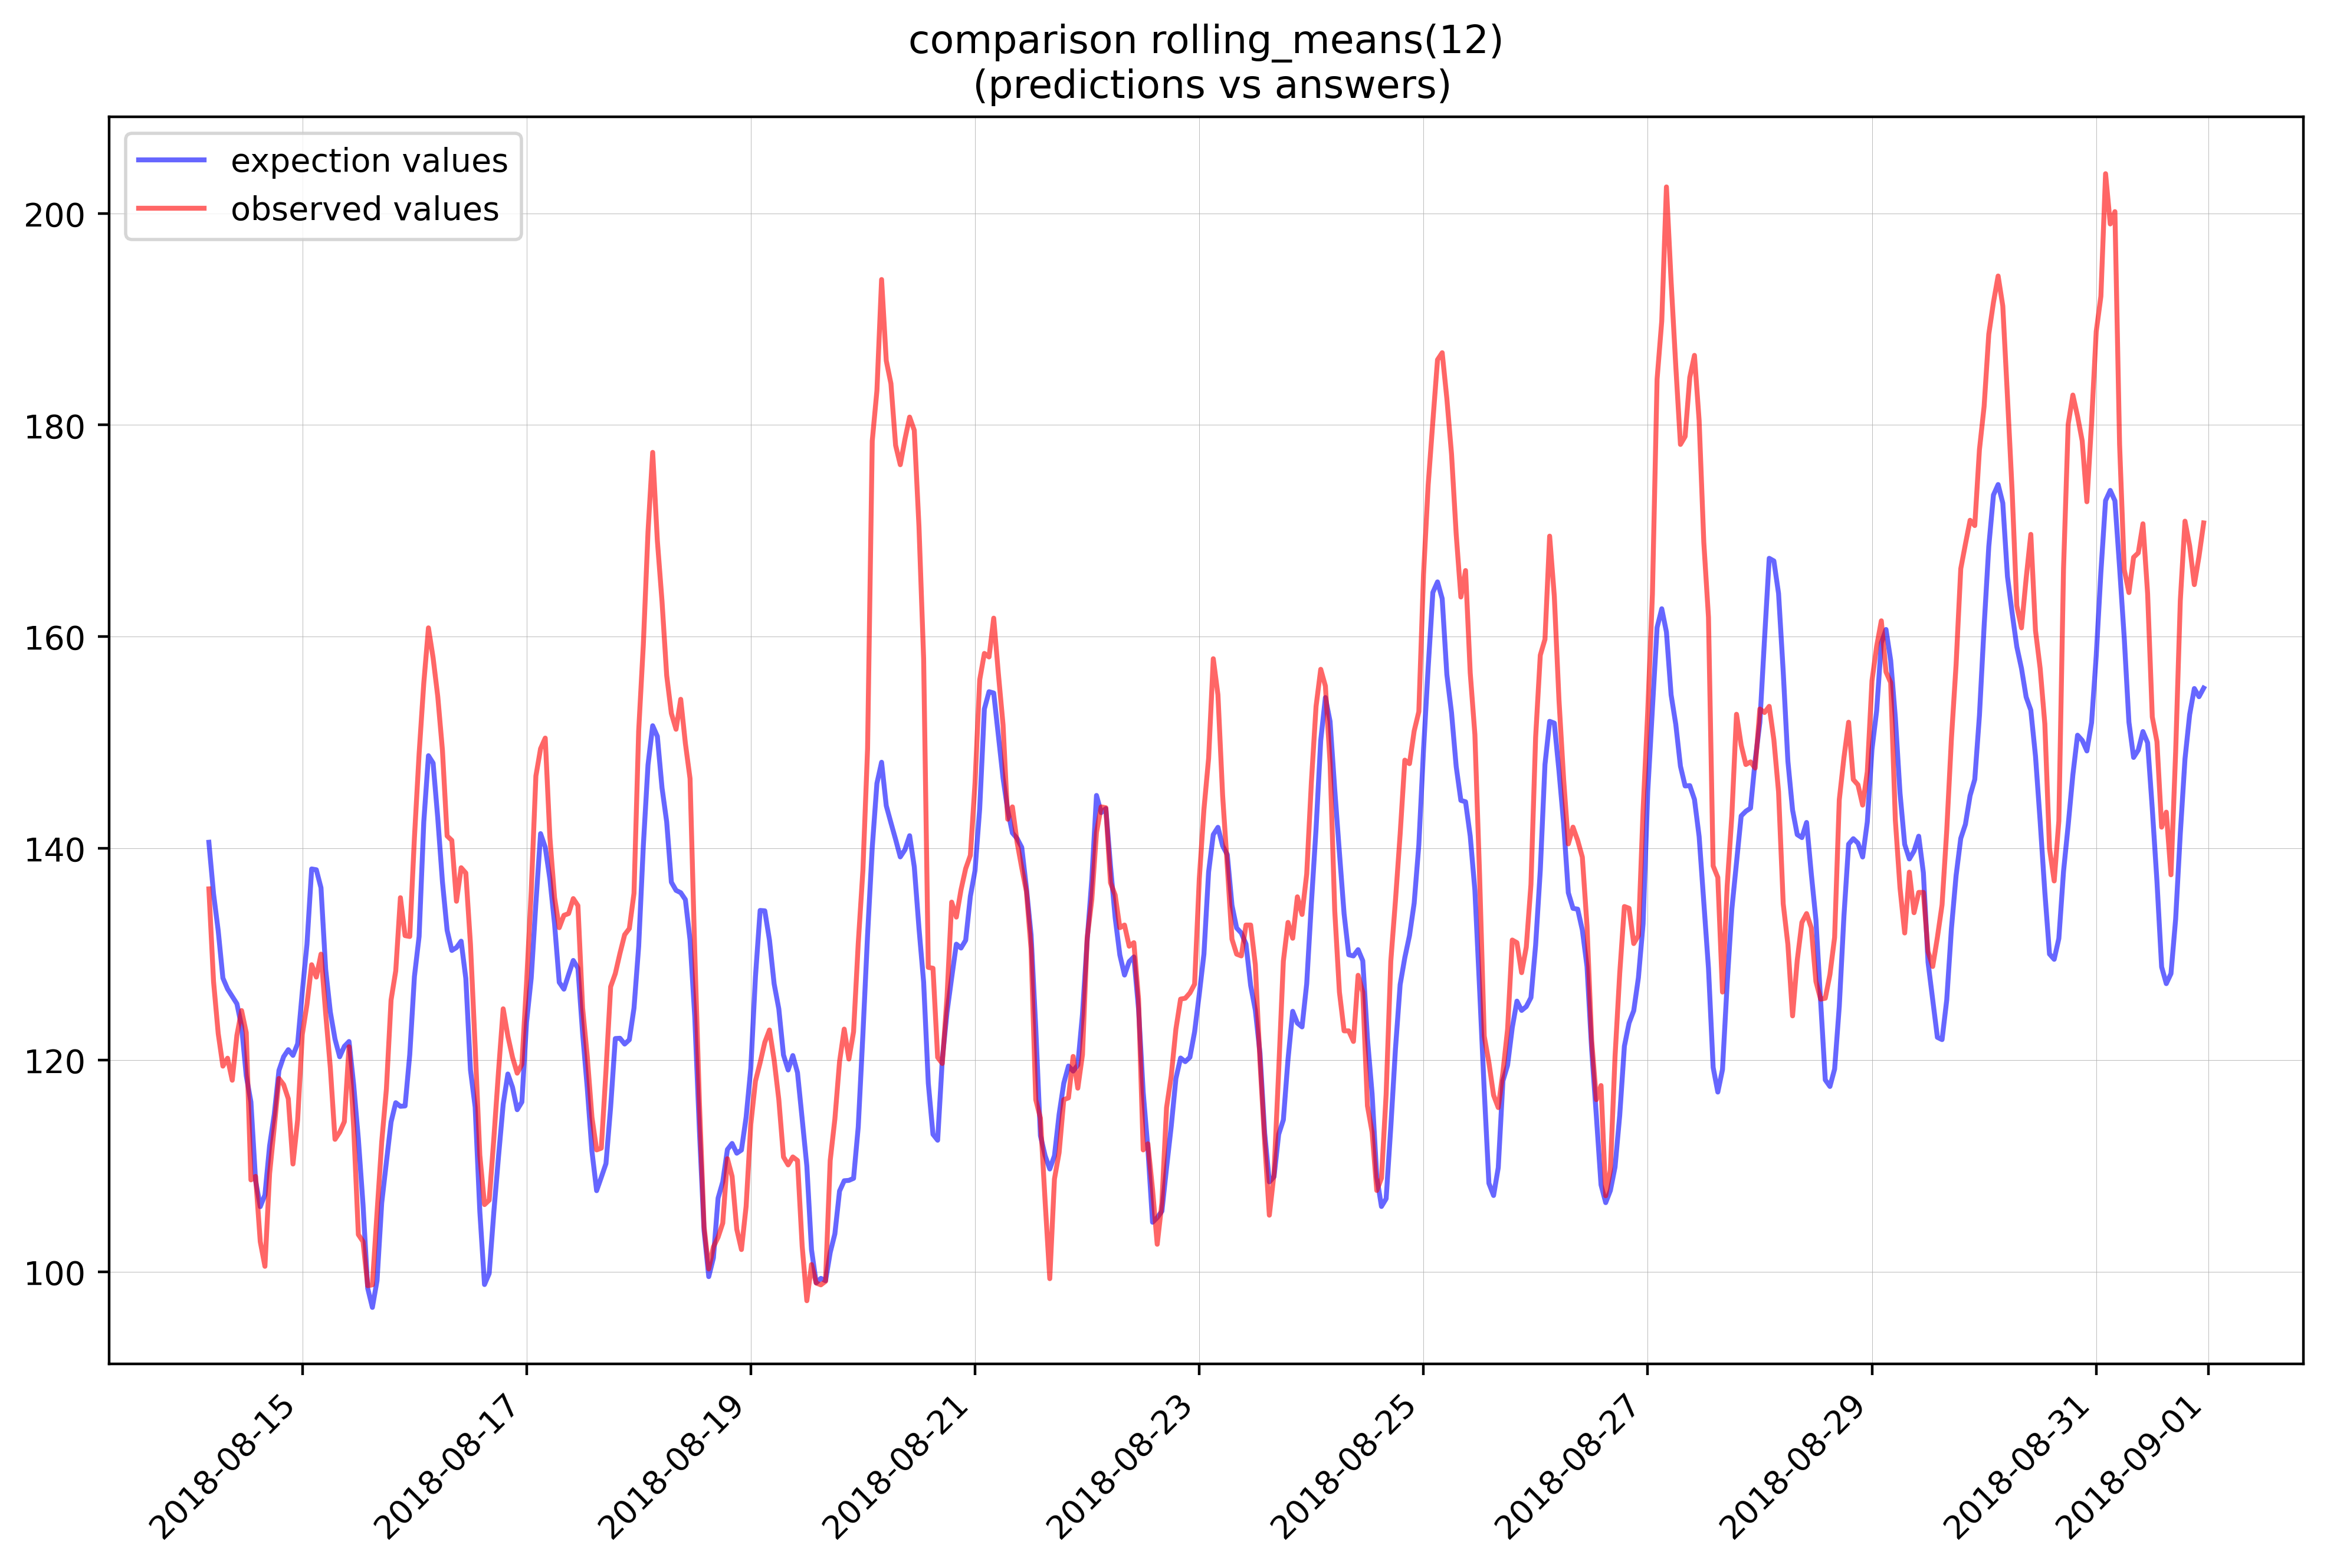

In [30]:
fig = plt.figure(figsize=(12, 7), dpi=400)
plt.plot(new['predict'].rolling(12).mean(), lw=1.5, alpha=0.6, color='blue'); 
plt.plot(new['test'].rolling(12).mean(), lw=1.5, alpha=0.6, color='red')
plt.grid(visible=True, lw=0.15)
plt.title('comparison rolling_means(12)\n (predictions vs answers)')
plt.legend(['expection values', 'observed values'])
plt.xticks(rotation=45, ha='right')
plt.show()

<div class="alert alert-block alert-success">
<b>Успех:</b> Тестирование было сделано корректно (за исключением разбиения). Хорошо, что предсказания были визуализированы
</div>

# Вывод

Был обработан временной ряд заказов в такси за 2018 год. Он обладал стационарностью относительно своего тренда. 

В признаки были занесены: 
* отстающие значения от 1 часа до суток (оптимальный параметр линейной ререссии)
* скользящее среднее за 34 часа (оптимальный параметр линейной ререссии)
* день недели 
* день месяца
* номер месяца

Для предсказания заказов была выбрана модель градиентного бустинга с параметрами: 

* 'num_leaves': 46, 
* 'max_bin': 100, 
* 'frac': 0.8
где frac - это размер остатка тренировочной выборки (первые 20% строк тренировочной выборки не рассматривались). 

В некоторые дни пики тестов были выше предсказаний, но пики предсказываются хорошо. На тестовой выборке модель показала значение метрики RMSE = 40.2, и r2_score = 0.53, что входит в допустимый предел ошибки в этом проекте. 

<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть вывод в конце проекта!
</div>